### Intro

In this notebook, we will model the light curves using the trained model from the previous notebook

### Import

In [4]:
import QNPy_Latte.PREDICTION as por #Importing PREDICTION_onePDF module from the package
from QNPy_Latte.PREDICTION import * #Importing importing all packages from PREDICTION_onePDF module
#The functions plot_function2, back_x and back_y must be imported separately
from QNPy_Latte.PREDICTION import plot_function2, back_x, back_y, find_LC_transform 

C:\Users\USER\anaconda3\envs\QNPy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Hyperparameters

In [6]:
#Model hyperparameters
#Match this to the previous model's hyperparameters
encoding_size = 128 #Encoder MLP layer size
latent_size = 128 #Latent dimension size
no_latent_samples = 10 #The number of samples of the latent space to take

attention_type = 'scaledot' #Can also use multihead, but scaledot works better
cross_attention = True #Whether to include cross-attention in the deterministic path
self_attention = True #Whether to include self-attention in both paths

lstm_layers = 0 #The number of LSTM layers to use for pre-encoding
lstm_size = 32 #The size of the LSTM layer

replace_lstm_with_gru = False # Whether to use a GRU instead of an LSTM
bidirectional = False #Whether to use bidirectional LSTM/GRU layers
lstm_agg = False #Whether to aggregate the latent space representations via an LSTM instead of mean pooling
activation = 'relu' #Can also make it 'leaky' for LeakyReLu but ReLu seems to work better
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #defining the device for testing, it can be CPU or CUDA

### TF and Param Hyperparameters

In [8]:
#The folder that all the files are in
full_folder = './'
suffix = f'LCs' #Whatever suffix you gave to the output files

In [9]:
#The paths for the transfer function and parameters if they exist
tf_and_param = True #Set false if using real data without transfer function and parameter
if tf_and_param:
    TF_PATH = f'Transfer_Functions/'
    param_df_path = 'Parameters.csv' #If there is no parameters dataframe, it should be None
    param_df = pd.read_csv(param_df_path)
    param_columns=['Log_Mass','Inclination','Log_Tau','z','Eddington_Ratio','SFinf'] #Change to the names of your columns
    param_length = len(param_columns)
    TF_SAVE_PATH_TRAIN = f'{full_folder}/output_{suffix}/predictions/Transfer_Functions/train/'
    TF_SAVE_PATH_TEST = f'{full_folder}/output_{suffix}/predictions/Transfer_Functions/test/'
    TF_SAVE_PATH_VAL = f'{full_folder}/output_{suffix}/predictions/Transfer_Functions/val/'
    PARAM_SAVE_PATH_TRAIN = f'{full_folder}/output_{suffix}/predictions/Parameter_Predictions/train/'
    PARAM_SAVE_PATH_VAL = f'{full_folder}/output_{suffix}/predictions/Parameter_Predictions/val/'
    PARAM_SAVE_PATH_TEST = f'{full_folder}/output_{suffix}/predictions/Parameter_Predictions/test/'
    beta_param = 0.1 #Change to the value you trained
    beta_tf = 0.1 #Change to the value you trained
    transfer_function_length = 1000 #Change to the appropriate tf_length
else:
    TF_PATH = None
    param_df = None
    param_columns = []
    param_length = 0
    beta_param = 0
    beta_tf = 0
    transfer_function_length = 0

### Creating Folders

We remove the padding from the curves. Thus, if you would like to train the model more, please save a copy of the dataset folder

In [12]:
#Creating the predictions folder
os.makedirs(f'{full_folder}/output_{suffix}/predictions',exist_ok=True)
os.makedirs(f'{full_folder}/output_{suffix}/predictions/Transfer_Functions/test',exist_ok=True)
os.makedirs(f'{full_folder}/output_{suffix}/predictions/Transfer_Functions/train',exist_ok=True)
os.makedirs(f'{full_folder}/output_{suffix}/predictions/Transfer_Functions/val',exist_ok=True)
os.makedirs(f'{full_folder}/output_{suffix}/predictions/Parameter_Predictions/test',exist_ok=True)
os.makedirs(f'{full_folder}/output_{suffix}/predictions/Parameter_Predictions/train',exist_ok=True)
os.makedirs(f'{full_folder}/output_{suffix}/predictions/Parameter_Predictions/val',exist_ok=True)
por.create_prediction_folders(f'{full_folder}/output_{suffix}/predictions')

Folder already exists: .//output_LCs/predictions\train
Folder already exists: .//output_LCs/predictions\train\plots
Folder already exists: .//output_LCs/predictions\train\data
Folder already exists: .//output_LCs/predictions\test
Folder already exists: .//output_LCs/predictions\test\plots
Folder already exists: .//output_LCs/predictions\test\data
Folder already exists: .//output_LCs/predictions\val
Folder already exists: .//output_LCs/predictions\val\plots
Folder already exists: .//output_LCs/predictions\val\data


In [13]:
#deleting the padded values from test set
folder_path = f'{full_folder}/dataset_{suffix}/test/'
por.remove_padded_values_and_filter(folder_path)

folder_path = f'{full_folder}/dataset_{suffix}/train/' 
por.remove_padded_values_and_filter(folder_path)

folder_path = f'{full_folder}/dataset_{suffix}/val/'  
por.remove_padded_values_and_filter(folder_path)

Removed padding in file: 16_split77.csv
Removed padding in file: 17_split25.csv
Removed padding in file: 24_split12.csv
Removed padding in file: 33_split46.csv
Removed padding in file: 42_split79.csv
Removed padding in file: 45_split89.csv
Removed padding in file: 50_split27.csv
Removed padding in file: 88_split47.csv
Removed padding in file: 100_split55.csv
Removed padding in file: 10_split91.csv
Removed padding in file: 11_split4.csv
Removed padding in file: 12_split87.csv
Removed padding in file: 13_split74.csv
Removed padding in file: 14_split11.csv
Removed padding in file: 15_split17.csv
Removed padding in file: 19_split33.csv
Removed padding in file: 1_split34.csv
Removed padding in file: 20_split45.csv
Removed padding in file: 21_split36.csv
Removed padding in file: 22_split28.csv
Removed padding in file: 23_split71.csv
Removed padding in file: 25_split85.csv
Removed padding in file: 26_split82.csv
Removed padding in file: 27_split65.csv
Removed padding in file: 28_split9.csv
Re

In [14]:
MODEL_PATH = f"{full_folder}/output_{suffix}/model_{suffix}.pth" #path to saved model
#Path to the data
DATA_PATH_TRAIN = f"{full_folder}/dataset_{suffix}/train"
DATA_PATH_VAL = f"{full_folder}/dataset_{suffix}/val"
DATA_PATH_TEST= f"{full_folder}/dataset_{suffix}/test"
OUTPUT_PATH = f'{full_folder}/output_{suffix}/predictions/' #path where to save the plots and data

In [15]:
#clearing outputh dir if you want. Uncomment the next line
#clear_output_dir=por.prepare_output_dir(OUTPUT_PATH)

In [16]:
#Load the saved model
model = por.load_trained_model(MODEL_PATH, device, encoding_size,latent_size,latent_mlp_size=encoding_size,attention = cross_attention,self_attention=self_attention,no_latent_space_sample=no_latent_samples,lstm_layers = lstm_layers,lstm_agg = lstm_agg,lstm_size=lstm_size,transfer_function_length=transfer_function_length,parameters_length = param_length,classes = 0,replace_lstm_with_gru=replace_lstm_with_gru
                                ,activation=activation,bidirectional=bidirectional)
#loading criterion and metrics
criterion, mseMetric=por.get_criteria()

In [17]:
#loading the coeffitients to transform back from [-2,2] to the real values
tr=por.load_trcoeff(f'{full_folder}/TR_Coeffs/trcoeff_{suffix}.pickle')

In [18]:
#The number of target points you want to model
num_target_smooth = 1000
#Load train data
trainLoader=por.load_train_data(DATA_PATH_TRAIN,num_target_smooth=num_target_smooth,tf_dir = TF_PATH,param_df=param_df,param_columns=param_columns,class_labels_df = None)
#Load test data
testLoader=por.load_test_data(DATA_PATH_TEST,num_target_smooth=num_target_smooth,tf_dir = TF_PATH,param_df=param_df,param_columns=param_columns,class_labels_df = None)
#Load val data
valLoader=por.load_val_data(DATA_PATH_VAL,num_target_smooth=num_target_smooth,tf_dir = TF_PATH,param_df=param_df,param_columns=param_columns,class_labels_df = None)

In [19]:
#Defining empty lists to store predictions
names = []
all_z = []
all_R = []
all_full_rep = []
all_predicted_tfs = []
all_predicted_params = []

## Reconstruction 

#### Test

In [22]:
#Get the names of the light curves and the transfer_function and params
transfer_functions_test = []
params_test = []
for i in testLoader:
    names.append(i['lcName'][0].split('_')[0])
    if tf_and_param:
        transfer_functions_test.append(i['transfer_function'][0].numpy())
        params_test.append(i['parameters'][0].numpy())
params_test = np.array(params_test)
transfer_functions_test = np.array(transfer_functions_test)

In [23]:
#prediction and ploting of test data
testMetrics,z_test,R_test, agg_R_z_test,predicted_params_test,predicted_tf_test,predicted_classes =por.plot_test_data(model, testLoader, criterion, mseMetric, plot_function2, device, tr,OUTPUT_PATH,beta_param = beta_param,beta_classifier=0,beta_tf=beta_tf)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.90it/s]


<Figure size 640x480 with 0 Axes>

In [24]:
#Save all the results to arrays
all_z.append(z_test)
all_R.append(R_test)
all_full_rep.append(agg_R_z_test)
all_predicted_tfs.append(predicted_tf_test)
all_predicted_params.append(predicted_params_test)

In [25]:
#saving test metrics
savetest=por.save_test_metrics(OUTPUT_PATH, testMetrics)

#### Train

In [27]:
#Get the names of the light curves and the transfer_function and params
transfer_functions_train = []
params_train = []
for i in trainLoader:
    names.append(i['lcName'][0].split('_')[0])
    if tf_and_param:
        transfer_functions_train.append(i['transfer_function'][0].numpy())
        params_train.append(i['parameters'][0].numpy())
params_train = np.array(params_train)
transfer_functions_train = np.array(transfer_functions_train)

In [28]:
#prediction and ploting of train data
trainMetrics,z_train,R_train,agg_R_z_train,predicted_params_train,predicted_tf_train,predicted_classes =por.plot_train_light_curves(model, trainLoader,criterion, mseMetric, plot_function2, device,tr,OUTPUT_PATH,beta_param = beta_param,beta_classifier=0,beta_tf=beta_tf)

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:28<00:00,  2.66it/s]


<Figure size 640x480 with 0 Axes>

In [29]:
#Save all the results to arrays
all_z.append(z_train)
all_R.append(R_train)
all_full_rep.append(agg_R_z_train)
all_predicted_tfs.append(predicted_tf_train)
all_predicted_params.append(predicted_params_train)

In [30]:
#Save the train metrics
savetrain=por.save_train_metrics(OUTPUT_PATH, trainMetrics)

#### Validation

In [32]:
#Get the names of the light curves and the transfer_function and params
transfer_functions_val = []
params_val = []
for i in valLoader:
    names.append(i['lcName'][0].split('_')[0])
    if tf_and_param:
        transfer_functions_val.append(i['transfer_function'][0].numpy())
        params_val.append(i['parameters'][0].numpy())
params_val = np.array(params_val)
transfer_functions_val = np.array(transfer_functions_val)

In [33]:
#Prediction and plotting of val data
valMetrics,z_val,R_val,agg_R_z_val,predicted_params_val,predicted_tf_val,predicted_classes =por.plot_val_curves(model, valLoader,criterion, mseMetric, plot_function2, device,tr,OUTPUT_PATH,beta_param = beta_param,beta_classifier=0,beta_tf=beta_tf)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.71it/s]


<Figure size 640x480 with 0 Axes>

In [34]:
#Save all the results to arrays
all_z.append(z_val)
all_R.append(R_val)
all_full_rep.append(agg_R_z_val)
all_predicted_tfs.append(predicted_tf_val)
all_predicted_params.append(predicted_params_val)

In [35]:
#Save all the hidden representations and names
with open(f'{suffix}_Rs.pickle', 'wb') as handle:
    pickle.dump(all_R, handle)
    
with open(f'{suffix}_zs.pickle', 'wb') as handle:
    pickle.dump(all_z, handle)
    
with open(f'{suffix}_full_reps.pickle', 'wb') as handle:
    pickle.dump(all_full_rep, handle)
    
with open(f'{suffix}_names.pickle', 'wb') as handle:
    pickle.dump(names, handle)

Now you are finished, unless you want to plot the transfer function and parameters

## Comparing Predicted TF and Parameters (OPTIONAL)

#### Test Data

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 243.16it/s]


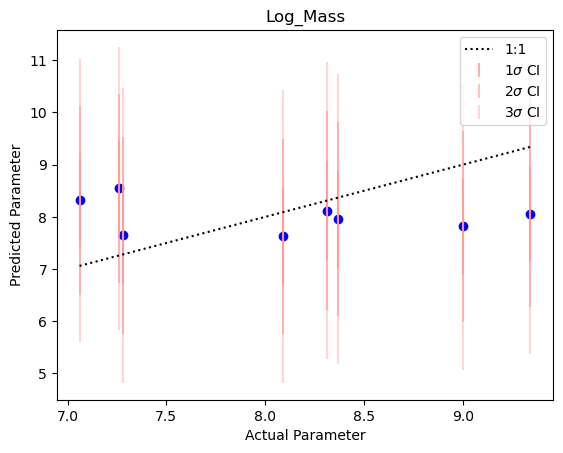

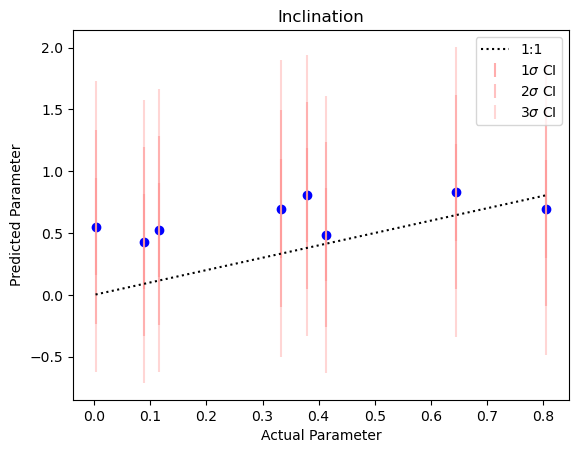

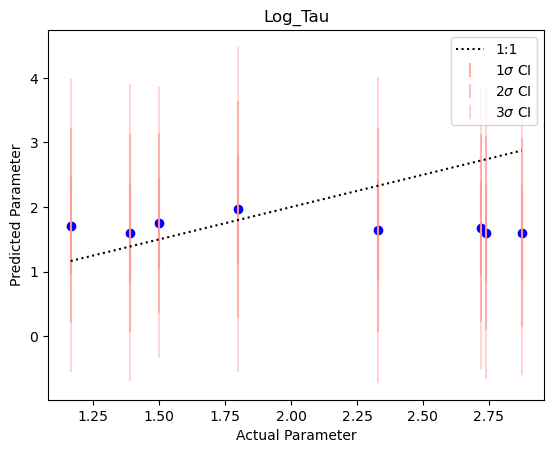

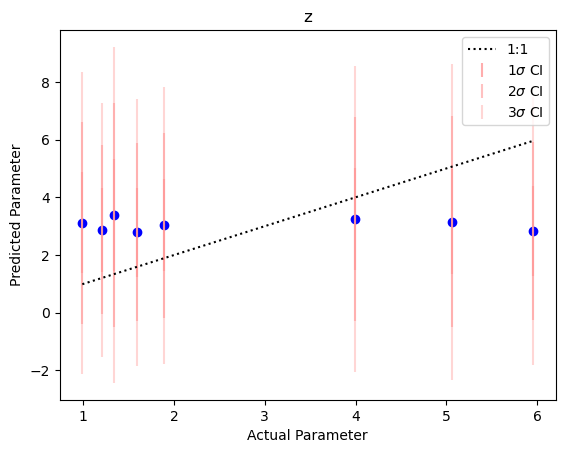

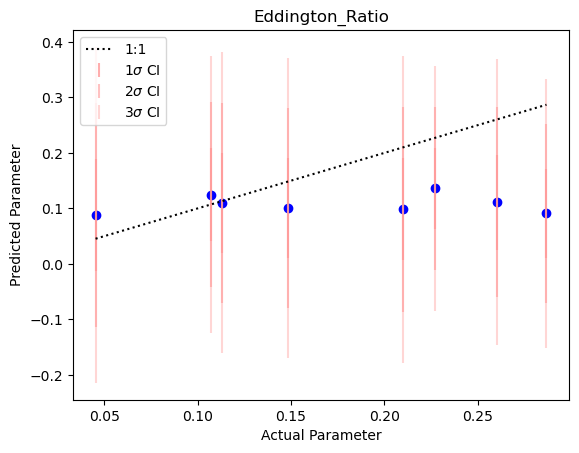

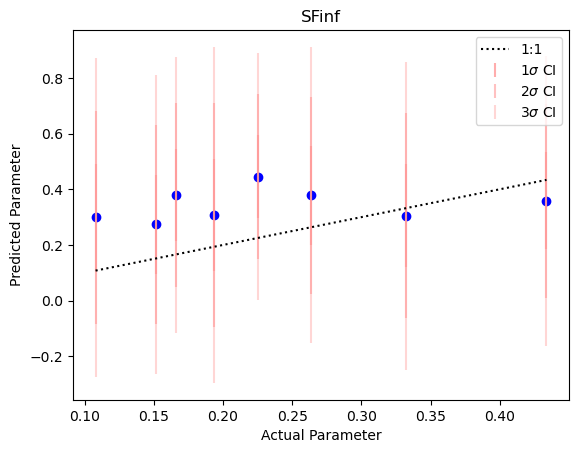

In [39]:
#Provide your ttau array
ttau = np.arange(1,1001)
ttau_plot_len = -1 #How much of the ttau do you want to plot
#Creating TF and Param Plots
Plotting_TF_Mean(predicted_tf_test,transfer_functions_test,ttau,TF_SAVE_PATH_TEST,ttau_plot_len)
Plotting_TF_Individual(testLoader,predicted_tf_test,transfer_functions_test,ttau,TF_SAVE_PATH_TEST,ttau_plot_len)
Plotting_Param_Individual(testLoader,predicted_params_test,params_test,param_columns,PARAM_SAVE_PATH_TEST)

#### Train Data

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 291.81it/s]


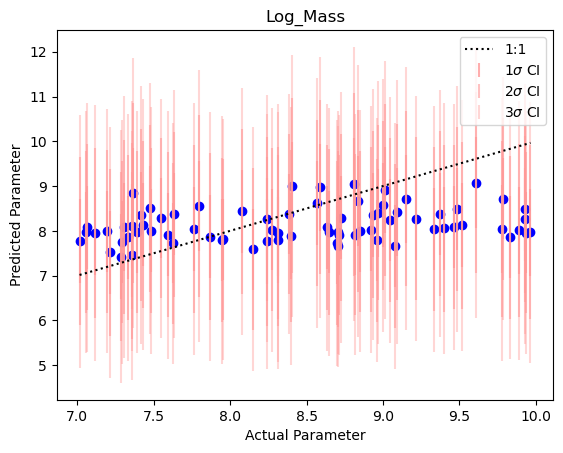

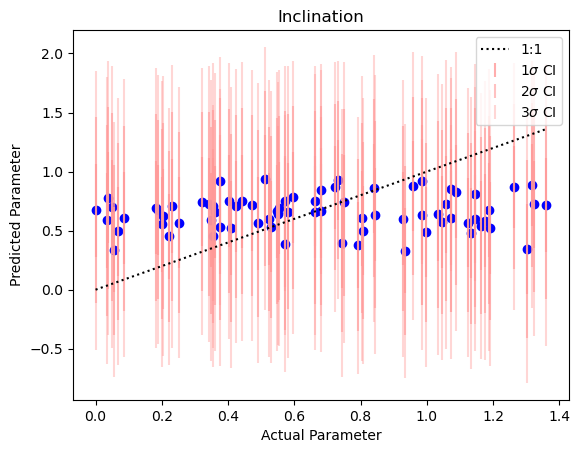

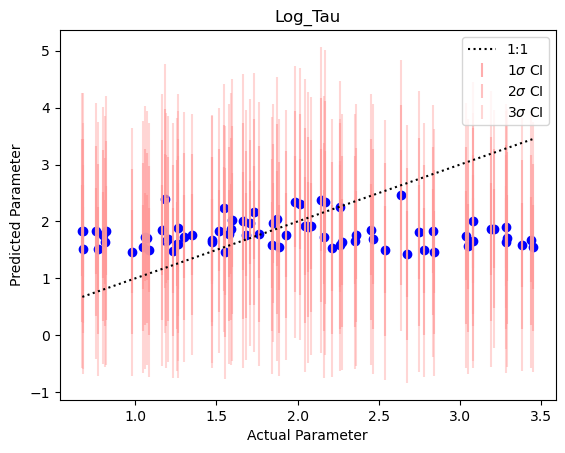

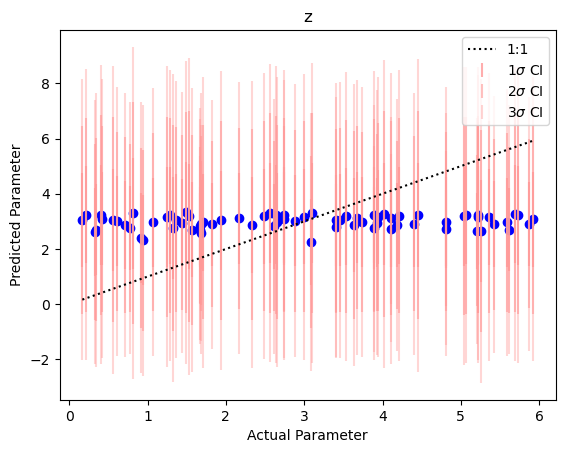

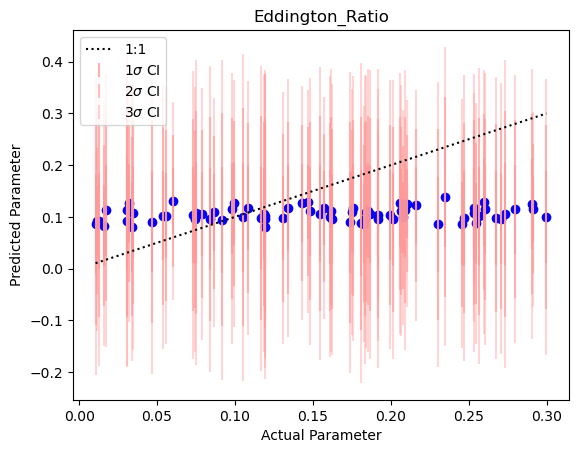

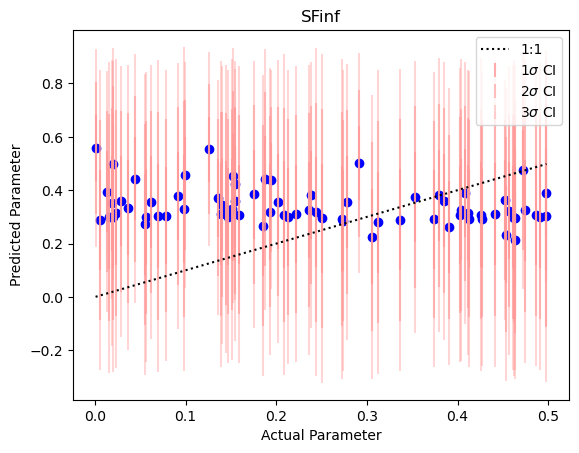

In [41]:
#Creating TF and Param Plots
Plotting_TF_Mean(predicted_tf_train,transfer_functions_train,ttau,TF_SAVE_PATH_TRAIN,ttau_plot_len)
Plotting_TF_Individual(trainLoader,predicted_tf_train,transfer_functions_train,ttau,TF_SAVE_PATH_TRAIN,ttau_plot_len)
Plotting_Param_Individual(trainLoader,predicted_params_train,params_train,param_columns,PARAM_SAVE_PATH_TRAIN)

#### Validation Data

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 235.83it/s]


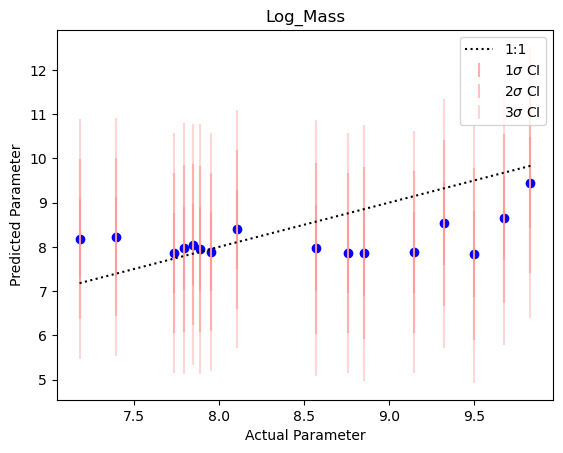

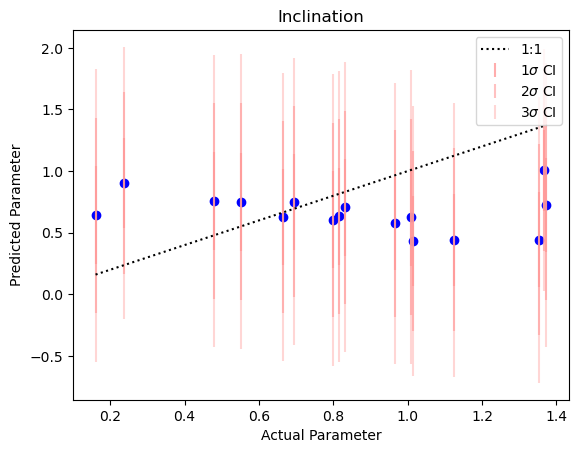

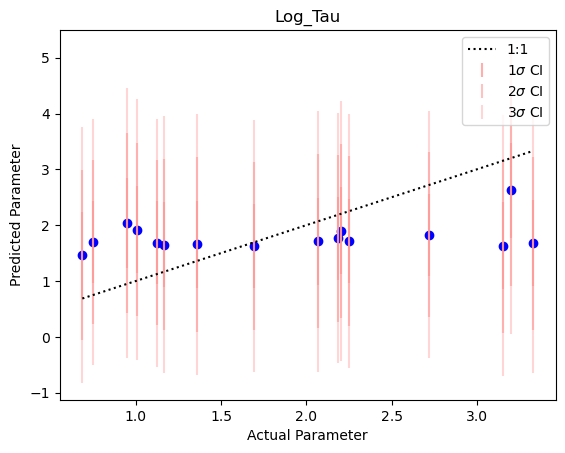

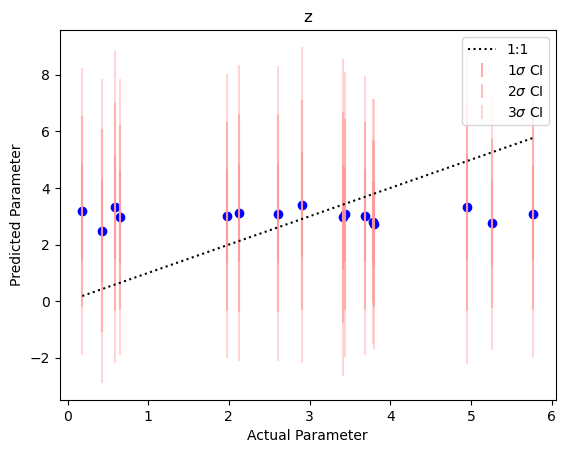

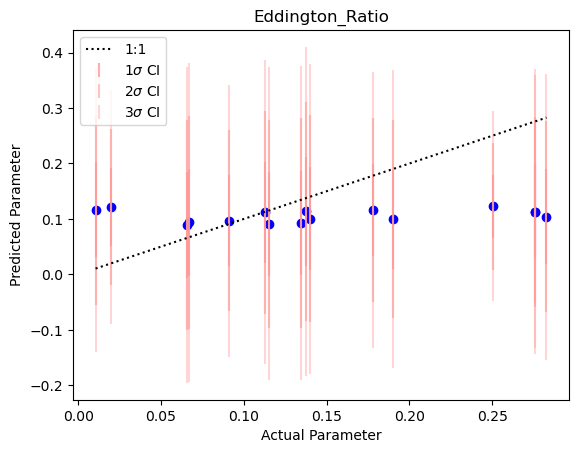

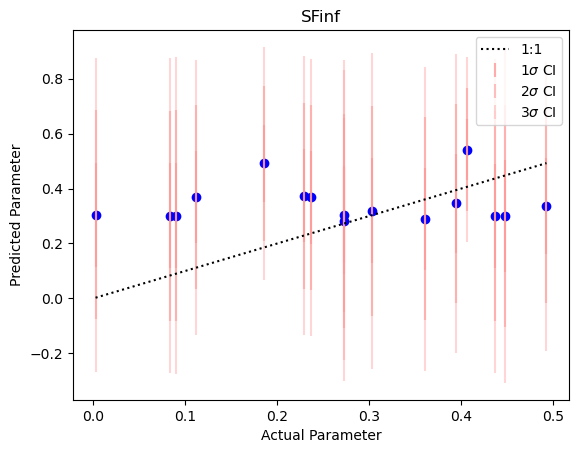

In [43]:
#Creating TF and Param Plots
Plotting_TF_Mean(predicted_tf_val,transfer_functions_val,ttau,TF_SAVE_PATH_VAL,ttau_plot_len)
Plotting_TF_Individual(valLoader,predicted_tf_val,transfer_functions_val,ttau,TF_SAVE_PATH_VAL,ttau_plot_len)
Plotting_Param_Individual(valLoader,predicted_params_val,params_val,param_columns,PARAM_SAVE_PATH_VAL)

Done!